<a href="https://colab.research.google.com/github/suren777/Ml-AI-in-finance/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural networks for curve predicrtion

In [0]:
!pip install -q keras

In [0]:
from keras.models import Model, save_model, load_model 
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras import regularizers
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import xml.etree.cElementTree as et
from copy import deepcopy
import os
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Data extraction
We use US Treasury data, available online. Following code downloads xmls and parse them into dataframe object.

In [0]:
link = r"https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/XmlView.aspx?data=yieldyear&year="
years = [2000 + y for y  in range(2,19)]
#years = [2018]

def read_xml(file):
    parseXML = et.parse(file)
    curve = []
    curve_labels = []
    first = True
    for node in parseXML.getroot():
        try:
            aux = node.find("{http://www.w3.org/2005/Atom}content").find('{http://schemas.microsoft.com/ado/2007/08/dataservices/metadata}properties')
            curve.append([elem.text for elem in aux])
            if first:
                curve_labels=[elem.tag.split('}')[1] for elem in aux]
                first = False
        except:
            pass
    return curve, curve_labels

def maybe_download(filename):
    if not os.path.exists(filename):
        first = True
        total = []
        labels = None
        for y in years:
            aux= urllib.request.urlopen(link+str(y))
            if first:
                curve, labels = read_xml(aux) 
                first                = False
            else:
                curve, _ = read_xml(aux)
            total.extend(deepcopy(curve))
        pd.DataFrame(total, columns = labels).sort_values(by='Id').to_csv(filename)

maybe_download("dataset.csv")


## Training dataset
In order to fix data from NaN values we first train autoencoder, on the train dataset.
We first do some tweaks to the data.
Secondly we define our autoencoder Layers using Keras. Still need to figure out optimal settings for it.

In [0]:

dataset = pd.read_csv('dataset.csv')[2260:]
val = dataset.drop(columns=dataset.columns[:3])
cols = dataset.columns[3:]
train = val.dropna().values/100.
val =val.values/100.
val[np.isnan(val)]=0
 
#scaler = preprocessing.StandardScaler().fit(train)
#train = scaler.transform(train)

In [0]:
print(train.shape)
print(val.shape)

(51, 13)
(1995, 13)


## Autoencoder 

---



In [0]:
N,M = train.shape # dimensions of the input data

hidden_layers = M-1
drop_rate=0.2

retrain = True
if retrain: 
  !rm autoencoder_model.h5


autoencoder_file = 'autoencoder_model.h5'
try:
    autoencoder = load_model(autoencoder_file)
except:
    input_data = Input(shape=(M,))
    hidden1=Dense(hidden_layers, activation='tanh')(input_data)
    drop1=Dropout(drop_rate)(hidden1)
    hidden2=Dense(int(hidden_layers/2), activation='tanh')(hidden1)
    drop2=Dropout(drop_rate)(hidden2)
    hidden3=Dense(hidden_layers, activation='tanh')(drop2)
    drop3=Dropout(drop_rate)(hidden3)
    out=Dense(M,activation='tanh')(drop3)

    autoencoder = Model(input_data, out)
    autoencoder.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error')

    autoencoder.fit(x=train, y=train, shuffle=True, epochs=20000, batch_size=1024, verbose=0)
    save_model(autoencoder,autoencoder_file)


rm: cannot remove 'autoencoder_model.h5': No such file or directory
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
!ls


autoencoder_model.h5  dataset.csv  sample_data


### Plot Results

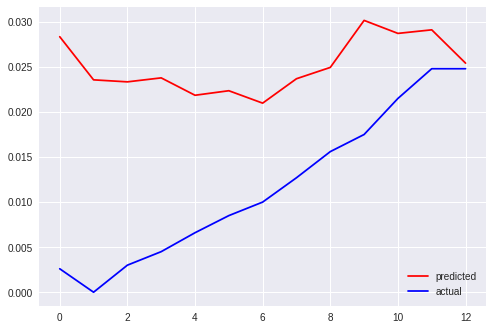

In [0]:
val_new = autoencoder.predict(val) # get values from autoencoder
n = np.random.choice(len(val_new))# plot number
plt.clf()
plt.plot(val_new[n],'r-')
plt.plot(val[n],'b-')
plt.legend(['predicted','actual'])
plt.show()

# Prediction model for the curve data

Firstly we need to prepare the training data. 
At the moment val_new is a time series of yiel curves ($R_t(T_0),...,R_t(T_N)$)
We want to predict the change in the curve value over time. 
From the paper (on prediction):
* Input = $(R_t(T_0),...,R_t(T_N), \delta R_t(T_0))$
* Output = $(\delta R_t(T_0),..., \delta R_t(T_N))$

In [0]:
yield_move = val_new[1:]-val_new[:-1]
X = np.hstack((val_new[:-1],yield_move[:,9:10]))
y = yield_move
split_pct=0.8
N,M = X.shape
test = int(N*split_pct)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Next we define layers of our network

* We also define regularisation parameter $\alpha$


In [0]:
alpha=0.0001
dp=0.2
inp_layer = Input(shape=(M,))
lnn1 = Dense(M+1, activation='tanh')(inp_layer)
dropr1 = Dropout(dp)(lnn1)
lnn2 = Dense(M+1, activation='tanh')(dropr1)
dropr2 = Dropout(dp)(lnn2)
output = Dense(M-1, activation='tanh')(dropr2)

Define the model:

In [0]:
regressor = Model(inp_layer, output)
regressor.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error')

**Train the model:**

In [0]:
regressor.fit(x=X_train, y=y_train, shuffle=True, epochs=50000, batch_size=1024, verbose=0)

## Plot Results

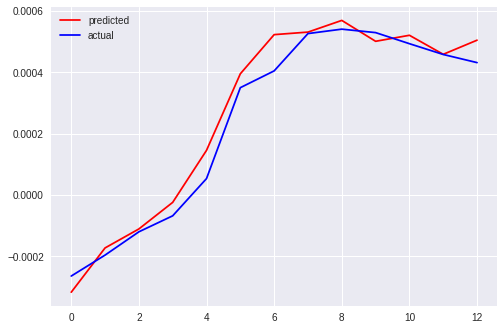

In [0]:
validation = regressor.predict(X_test)
m=len(validation)

m1 = np.random.choice(m)

plt.plot(validation[m1],'r-')
plt.plot(y_test[m1],'b-')
plt.legend(['predicted', 'actual'])
plt.show()